In [1]:
%tensorflow_version 1.14.x # Can only select major right now, but what we need is, in theory, this
import tensorflow as tf

# Download the code
!git clone --recurse-submodules https://github.com/harshanikhilgupta/Anime.git
%cd Anime
!nvcc stylegan2/test_nvcc.cu -o test_nvcc -run

!nvidia-smi -L
print('GPU Identified at: {}'.format(tf.test.gpu_device_name()))

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14.x # Can only select major right now, but what we need is, in theory, this`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
fatal: destination path 'Anime' already exists and is not an empty directory.
/content/Anime
CPU says hello.
GPU says hello.
GPU 0: Tesla T4 (UUID: GPU-77696dc1-19dd-29a3-b488-c650ace9a65a)
GPU Identified at: /device:GPU:0


In [3]:
import os
import pickle
import numpy as np
import numpy.linalg as la

import PIL.Image
import PIL.ImageSequence

import moviepy
import moviepy.editor
import math
import glob
import csv
from functools import partial
import time
import collections

import sys
sys.path.append("stylegan2")

import run_projector
import projector
import dnnlib
import dnnlib.tflib as tflib

import tensorflow as tf

import keras
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, ElasticNet
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

import colorsys
import re
import copy

from IPython.display import display, clear_output
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
import glob
import gc
import io

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)4005888/45929032 bytes (8.7%)8265728/45929032 bytes (18.0%)12419072/45929032 bytes (27.0%)16482304/45929032 bytes (35.9%)20062208/45929032 bytes (43.7%)24068096/45929032 bytes (52.4%)28344320/45929032 bytes (61.7%)32456704/45929032 bytes (70.7%)36651008/45929032 bytes (79.8%)40910848/45929032 bytes (89.1%)45064192/45929032 bytes (98.1%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

Using TensorFlow backend.


In [4]:
# If this doesn't say 1.14.0, it probably will not work. Stylegan2 is picky. 1.15 MAY be okay, depending.
# Additionally, you'll need some compiler so nvcc can work (add the path in custom_ops.py if needed)
# In summary, the best time for google to stop making breaking changes to tensorflow was 2 years ago
tf.__version__

'1.15.2'

In [5]:
# Download the model
%cd stylegan2_animeface_model/
!gdown https://drive.google.com/u/0/uc?id=1uouxd9q6M4Gcbrve3R9Fi2qUpy9ZSCdG&export=download
%cd ..

/content/Anime/stylegan2_animeface_model
Downloading...
From: https://drive.google.com/u/0/uc?id=1uouxd9q6M4Gcbrve3R9Fi2qUpy9ZSCdG
To: /content/Anime/stylegan2_animeface_model/2020-01-11-skylion-stylegan2-animeportraits-networksnapshot-024664.pkl
364MB [00:03, 108MB/s]
/content/Anime


In [6]:
##
# 0. Load network snapshots
##

# From https://mega.nz/#!PeIi2ayb!xoRtjTXyXuvgDxSsSMn-cOh-Zux9493zqdxwVMaAzp4 - gwern animefaces stylegan2
input_sg_name = "stylegan2_animeface_model/2020-01-11-skylion-stylegan2-animeportraits-networksnapshot-024664.pkl"

tflib.init_tf()

# Load pre-trained network.
with open(input_sg_name, 'rb') as f:
    # _G = Instantaneous snapshot of the generator. Mainly useful for resuming a previous training run.
    # _D = Instantaneous snapshot of the discriminator. Mainly useful for resuming a previous training run.
    # Gs = Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.    
    _G, _D, Gs = pickle.load(f)
        
# Print network details.
Gs.print_layers()
_D.print_layers()

# For projection
proj = projector.Projector()
proj.set_network(Gs)

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.

Gs                            Params    OutputShape         WeightShape     
---                           ---       ---                 ---             
latents_in                    -         (?, 512)            -               
labels_in                     -         (?, 0)              -               
lod                           -         ()                  -               
dlatent_avg                   -         (512,)              -               
G_mapping/latents_in          -         (?, 512)            -               
G_mapping/labels_in           -         (?, 0)              -               
G_mapping/Normalize           -         (?, 512)            -               
G_mapping/Dense0              262656    (?, 512)            (512, 512)      
G_mapping/Dense1              262656   

In [7]:
def generate_from_latents(latent_list, truncation_psi):
    array_list = []
    image_list = []
    for latents in latent_list:
        # Generate image.
        fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
        images = Gs.run(latents, None, truncation_psi=truncation_psi, randomize_noise=False, output_transform=fmt)
        array_list.append(images[0])
        image_list.append(PIL.Image.fromarray(images[0], 'RGB'))
        
    return array_list, image_list

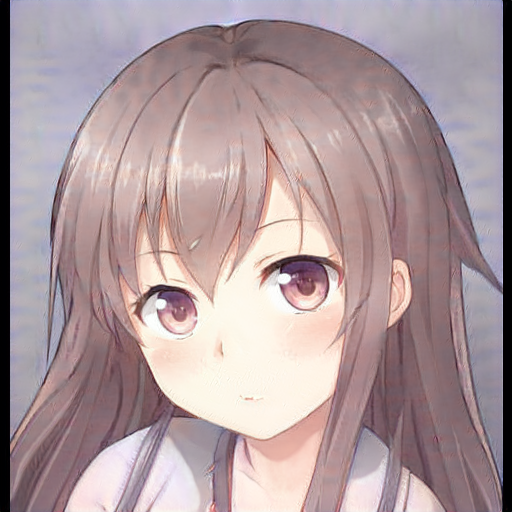

In [8]:
arrays, images = generate_from_latents([np.random.randn(1, Gs.input_shape[1])], 0.5)
images[0]